## Lassonet Demo Notebook - PyTorch

This notebook illustrates the Lassonet method for feature selection on a classification task.
We will run Lassonet over [the Mice Dataset](https://archive.ics.uci.edu/ml/datasets/Mice%20Protein%20Expression). This dataset consists of protein expression levels measured in the cortex of normal and trisomic mice who had been exposed to different experimental conditions. Each feature is the expression level of one protein.

First we import a few necessary packages

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from lassonet.lassonet_trainer import lassonet_trainer

Then, loading the Mice dataset

In [2]:
def load_mice(one_hot = False):
    filling_value = -100000
    X = np.genfromtxt('Data_Cortex_Nuclear.csv', delimiter = ',', skip_header = 1, usecols = range(1, 78), filling_values = filling_value, encoding = 'UTF-8')
    classes = np.genfromtxt('Data_Cortex_Nuclear.csv', delimiter = ',', skip_header = 1, usecols = range(78, 81), dtype = None, encoding = 'UTF-8')

    for i, row in enumerate(X):
        for j, val in enumerate(row):
            if val == filling_value:
                X[i, j] = np.mean([X[k, j] for k in range(classes.shape[0]) if np.all(classes[i] == classes[k])])

    DY = np.zeros((classes.shape[0]), dtype = np.uint8)
    for i, row in enumerate(classes):
        for j, (val, label) in enumerate(zip(row, ['Control', 'Memantine', 'C/S'])):
            DY[i] += (2 ** j) * (val == label)

    Y = np.zeros((DY.shape[0], np.unique(DY).shape[0]))
    for idx, val in enumerate(DY):
        Y[idx, val] = 1

    X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    DY = DY[indices]
    classes = classes[indices]
    
    if not one_hot:
        Y = DY
        
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    
    print(X.shape, Y.shape)
    
    return (X[: X.shape[0] * 4 // 5], Y[: X.shape[0] * 4 // 5]), (X[X.shape[0] * 4 // 5:], Y[X.shape[0] * 4 // 5: ])

name = 'mice'
train, test = load_mice()

(1080, 77) (1080,)


LassoNet natively convers the data into PyTorch Tensors, and is GPU-compatible. If the machine has a GPU, it will be used for training. Otherwise, it defaults to CPU.

LassoNet uses a training loop typical of PyTorch. We begin by training an initial fully dense, and use it as warm start over the entire regularization path. The entire training loop takes less than 5 min on a Tesla K80 GPU.

In [4]:
lassonet_results = lassonet_trainer(name, train, test)

dense model achieved train/test accuracy:0.990/0.954 after 1330 epochs
selected 76 features
selected 75 features
selected 71 features
selected 70 features
selected 61 features
selected 56 features
selected 49 features
selected 41 features
selected 35 features
selected 34 features
selected 33 features
selected 32 features
selected 31 features
selected 30 features
selected 28 features
selected 26 features
selected 25 features
selected 23 features
selected 20 features
selected 19 features
selected 18 features
selected 16 features
selected 15 features
selected 14 features
selected 13 features
selected 11 features
selected 9 features
selected 8 features
selected 7 features
selected 5 features
selected 4 features
selected 3 features
selected 2 features
selected 1 features


The classification accuracy is plotted below:

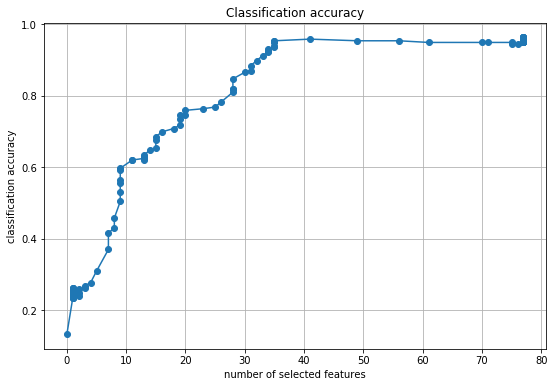

In [17]:
nselected = lassonet_results['nselected']
accuracy = lassonet_results['test_accuracy']

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (9,6))
plt.grid(True)
plt.plot(nselected, accuracy, 'o-')
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")
plt.title("Classification accuracy")
plt.savefig('fig1.png')
plt.show()

To view the selected features, we can load the 'indices' list from the trainer.

In [16]:
import pickle
indices = pickle.load(open(name+'-indices.pkl','rb'))
print(indices['lassonet'])

{77: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76]), 76: array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76]), 75: array([ 0,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
 